In [323]:
from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np

In [324]:
torch.manual_seed(265)
torch.set_default_dtype(torch.double)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [325]:
scale_w_loc, scale_h_loc, scale_w_det, scale_h_det = 60, 48, 20, 24

## 2. Object Localization

2.1.1 Load the 3 localization datasets localization_XXX.pt. There is at most one digit per image. All digits are represented (C = 10).

In [326]:
x_train = torch.load('.\data\localization_train.pt')
x_val = torch.load('.\data\localization_val.pt')
x_test = torch.load('.\data\localization_test.pt')

In [327]:
# size of each dataset
print(f"train/val/test sizes: {len(x_train)}/{len(x_val)}/{len(x_test)}")

train/val/test sizes: 59400/6600/11000


In [328]:
# shape of the input and target tensors
print(f"Shape of input tensors: {x_train[0][0].shape}")
print(f"Shape of target tensors: {x_train[0][1].shape}")

Shape of input tensors: torch.Size([1, 48, 60])
Shape of target tensors: torch.Size([6])


In [329]:
def xywh_bounding_box_loc(tensor):
    x, y = tensor[1] * scale_w_loc, tensor[2] * scale_h_loc
    w, h = tensor[3] * scale_w_loc, tensor[4] * scale_h_loc
    left_corner, bottom_corner = x - w / 2, y - h / 2

    return left_corner, bottom_corner, w, h

In [330]:
def plot_data_loc(data, title):
    fig = plt.figure(figsize=(8, 8))
    for i in range(25):
        ax = fig.add_subplot(5, 5, i + 1)
        input_tensor, output_tensor = data[i]

        x, y, w, h = xywh_bounding_box_loc(output_tensor)
        bin_val, y_true = output_tensor[0], output_tensor[5]

        if bin_val:
            ax.add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor="g", facecolor="none"))
            ax.set_title(f"y_true: {int(y_true)}")
        else:
            ax.set_title("-")

        ax.imshow(input_tensor.squeeze().numpy(), cmap="Greys")
        ax.axis("off")

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=1)
    plt.show()

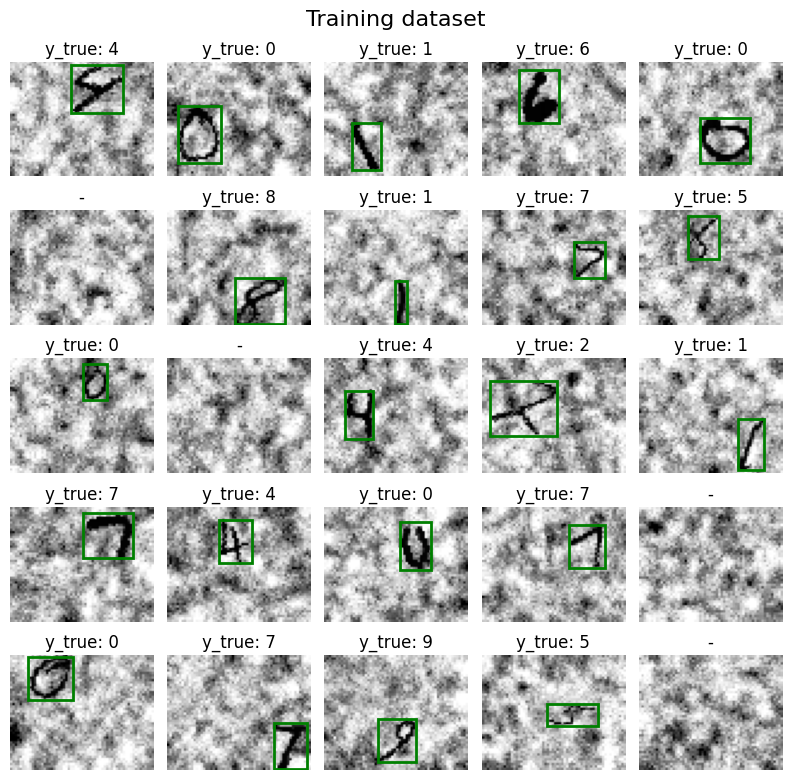

In [331]:
plot_data_loc(x_train, "Training dataset")

In [332]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(960, 128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.ReLU(),
            nn.Linear(84, 15)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x.double()

In [389]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 15)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [333]:
BCEWithLogitsLoss = nn.BCEWithLogitsLoss()
Sigmoid = nn.Sigmoid()
MSELoss = nn.MSELoss()
CrossEntropyLoss = nn.CrossEntropyLoss()


def loss_fn_loc(y_true, y_pred):
    L_A = BCEWithLogitsLoss(y_pred[:, 0], y_true[:, 0])
    mask = torch.where((Sigmoid(y_pred[:, 0]) > 0.5) & (y_true[:, 0] == 1))[0]

    L_B, L_C = 0, 0

    if len(mask) > 0:
        L_B = MSELoss(y_pred[mask, 1:5], y_true[mask, 1:5])
        L_C = CrossEntropyLoss(y_pred[mask, 5:], y_true[mask, 5].to(torch.long))

    return L_A + L_B + L_C

In [334]:
def iou(y_true, y_pred):
    x_t, y_t, w_t, h_t = y_true[:, 0], y_true[:, 1], y_true[:, 2], y_true[:, 3]
    x_p, y_p, w_p, h_p = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]

    smoothing_factor = 1e-10

    # find the coordinates of the intersection rectangle
    x_left, y_top = torch.max(x_t, x_p), torch.max(y_t, y_p)
    x_right, y_bottom = torch.min(x_t + w_t, x_p + w_p), torch.min(y_t + h_t, y_p + h_p)

    # calculate the area of intersection rectangle
    intersection_area = torch.clamp(x_right - x_left, min=0) * torch.clamp(y_bottom - y_top, min=0)

    # calculate the area of the union rectangle
    union_area = w_t * h_t + w_p * h_p - intersection_area

    # calculate the IoU
    return intersection_area / torch.clamp(union_area, min=smoothing_factor)

In [335]:
def convert_to_digit(y_pred):
    # apply sigmoid activation to p_c column and threshold at 0.5
    y_pred[:, 0] = (Sigmoid(y_pred[:, 0]) > 0.5).float()

    # find the index of the class with the maximum probability
    _, class_indices = torch.max(y_pred[:, 5:], dim=1, keepdim=True)

    # update the class labels in the original tensor
    y_pred[:, 5:] = class_indices.float()

    # select only the first two columns (p_c and class label)
    pred = y_pred[:, :6]

    return pred

In [336]:
def performance(y_true, y_pred):
    y_pred = convert_to_digit(y_pred)
    accuracy_values = [1 if y_true[i, 0] == y_pred[i, 0] and y_true[i, 5] == y_pred[i, 5]
                       else 0 for i in range(len(y_pred))]
    accuracy_val = torch.mean(torch.Tensor(accuracy_values))

    iou_values = iou(y_true[:, 1:5], y_pred[:, 1:5])
    iou_val = torch.mean(iou_values)

    return [accuracy_val, iou_val, torch.mean(torch.Tensor([accuracy_val, iou_val]))]

2.1.2 Implement and train several convolutional models suitable for an object localization task and the data provided.

In [337]:
def train_loc(n_epochs, model, optimizer, loader):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    losses, performs = [], []

    for epoch in range(n_epochs):
        epoch_loss, epoch_perform = [], []

        for imgs, y_true in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            y_true = y_true.to(device=device)

            y_pred = model(imgs)

            loss = loss_fn_loc(y_true.float(), y_pred.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            perform = performance(y_true, y_pred)[2]
            epoch_loss.append(loss.item())
            epoch_perform.append(perform.item())

        losses.append(np.mean(epoch_loss))
        performs.append(np.mean(epoch_perform))

        print(f"Epoch {epoch + 1}: {performs[-1]}, {losses[-1]}")

    return performs, losses

In [341]:
batch_size_loc = 128
lr_loc = 1e-3
epochs_loc = 20

train_loader_loc = torch.utils.data.DataLoader(x_train, batch_size=batch_size_loc, shuffle=True)
val_loader_loc = torch.utils.data.DataLoader(x_val, batch_size=batch_size_loc, shuffle=True)

In [342]:
LeNet5_model_loc = LeNet5().to(device)
LeNet5_optimizer_loc = torch.optim.Adam(LeNet5_model_loc.parameters(), lr=lr_loc)

In [390]:
VGG16_model_loc = VGG16().to(device)
VGG16_optimizer_loc = torch.optim.Adam(VGG16_model_loc.parameters(), lr=lr_loc)

In [343]:
perform_LeNet5_loc, losses_LeNet5_loc = train_loc(epochs_loc, LeNet5_model_loc, LeNet5_optimizer_loc, train_loader_loc)

Epoch 1: 0.18297725373378995, 2.448068690812716
Epoch 2: 0.3185715432692912, 2.0944765998471166
Epoch 3: 0.34358591483502826, 1.901213356756395
Epoch 4: 0.42226636161649206, 1.591382187668995
Epoch 5: 0.46521557821779763, 1.2976108856098627
Epoch 6: 0.5033504411750048, 1.112522215099745
Epoch 7: 0.5354366455323062, 0.9853962829036097
Epoch 8: 0.559468095207261, 0.8731260266355289
Epoch 9: 0.5752189852341952, 0.7881813983122508
Epoch 10: 0.5892497167607881, 0.7139914502379715
Epoch 11: 0.602294320316831, 0.6415809089137662
Epoch 12: 0.6120127385324255, 0.5925785815843971
Epoch 13: 0.6216160840887093, 0.5453841061361374
Epoch 14: 0.6288787301476029, 0.5118309616401632
Epoch 15: 0.6334582940637213, 0.47755778069778154
Epoch 16: 0.6389373489127035, 0.45258927044048103
Epoch 17: 0.6443267619035741, 0.4274332203531778
Epoch 18: 0.646139704197565, 0.40347341766921424
Epoch 19: 0.6513945722071974, 0.37832766684793656
Epoch 20: 0.6548062878598894, 0.35696587825334203


In [391]:
perform_VGG16_loc, losses_VGG16_loc = train_loc(epochs_loc, VGG16_model_loc, VGG16_optimizer_loc, train_loader_loc)

KeyboardInterrupt: 

In [348]:
def plot_train_loss_and_performance(epochs, performance, train_loss):
    epochs = range(1, epochs + 1)
    plt.plot(epochs, performance, 'r', label='Performance')
    plt.plot(epochs, train_loss, 'bo', label='Training Loss')
    plt.title('Training Loss and Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Metric')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

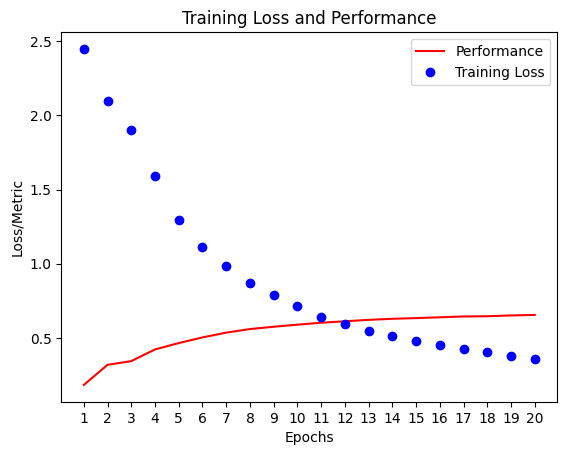

In [349]:
plot_train_loss_and_performance(epochs_loc, perform_LeNet5_loc, losses_LeNet5_loc)

 2.1.3 Select the best model based on its overall performance

In [352]:
def model_performance(model, loader, performance_fn, det=False):
    model.eval()

    a_list, i_list, p_list = [], [], []
    with torch.no_grad():
        for imgs, y_true in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            y_true = y_true.to(device=device)

            y_pred = model(imgs)

            if det:
                y_pred = y_pred.reshape([y_pred.size()[0], 2, 3, 7])

            a, i, p = performance_fn(y_true, y_pred)
            a_list.append(a.item())
            i_list.append(i.item())
            p_list.append(p.item())

        accuracy_val = np.mean(a_list)
        iou_val = np.mean(i_list)
        perform_val = np.mean(p_list)

        print(f"Accuracy/IOU/Performance: {accuracy_val}/{iou_val}/{perform_val}")

In [353]:
LeNet5_performance = model_performance(LeNet5_model_loc, train_loader_loc, performance)

Accuracy/IOU/Performance: 0.9030577956989247/0.40922354113877424/0.6561406684188495


2.1.5 Plot some of the images of the datasets and draw the predicted and true bounding boxes. Print their true and predicted labels as well.

In [354]:
def plot_pred(model, loader, title):
    fig = plt.figure(figsize=(8, 8))
    for i in range(25):
        ax = fig.add_subplot(5, 5, i + 1)
        batch = next(iter(loader))

        imgs, y_true = batch
        imgs = imgs.to(device=device, dtype=torch.double)

        y_pred = model(imgs)
        y_pred = convert_to_digit(y_pred)

        imgs, y_pred = imgs.cpu(), y_pred.data.cpu()

        ax.imshow(imgs[0][0], cmap="gray_r")
        plt.title(f"y_true: {int(y_true[0][5])}, y_pred: {int(y_pred[0][5])}", fontsize=7)

        x_t, y_t, w_t, h_t = xywh_bounding_box_loc(y_true[0])
        x_p, y_p, w_p, h_p = xywh_bounding_box_loc(y_pred[0])

        ax.add_patch(Rectangle((x_t, y_t), w_t, h_t, linewidth=1, edgecolor="g", facecolor="none"))
        ax.add_patch(Rectangle((x_p, y_p), w_p, h_p, linewidth=1, edgecolor="r", facecolor="none"))

        ax.legend(["y_true", "y_pred"], ncol=2, fontsize=5, loc="upper center", bbox_to_anchor=(0.5, -0.01))
        ax.axis("off")

    fig.suptitle(title)
    fig.show()

C:\Users\Alina Artemiuk\AppData\Local\Temp\ipykernel_15088\3594605390.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


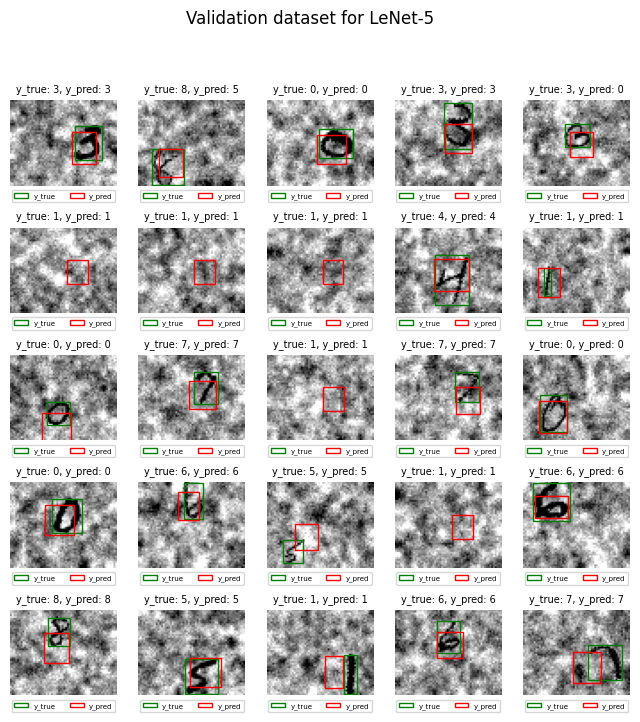

In [380]:
plot_pred(LeNet5_model_loc, val_loader_loc, "Validation dataset for LeNet-5")

# 3.1 Object Detection

3.1.2.1 Load the 3 detection datasets detection_XXX.pt. They correspond to the same expected outputs as in list_y_true_XXX.pt files, except that they are already processed for a 2 x 3 grid, each cell of dimension 24 x 20. When using this data preparation, we then have H_out = 2 and W_out = 3 and y_true is a tensor of shape (N_tot, H_out, W_out, 6) with N_tot, the total number of images in the dataset.

In [356]:
x_train_det = torch.load("./data/detection_train.pt")
x_val_det = torch.load("./data/detection_val.pt")
x_test_det = torch.load("./data/detection_test.pt")

In [359]:
# size of each dataset
print(f"train/val/test sizes: {len(x_train_det)}/{len(x_val_det)}/{len(x_test_det)}")

train/val/test sizes: 26874/2967/4981


In [360]:
# shape of the input and target tensors
print(f"Shape of input tensors: {x_train_det[0][0].shape}")
print(f"Shape of target tensors: {x_train_det[0][1].shape}")

Shape of input tensors: torch.Size([1, 48, 60])
Shape of target tensors: torch.Size([2, 3, 6])


In [361]:
def xywh_bounding_box_det(tensor, height, width):
    x, y = tensor[1] * scale_w_det, tensor[2] * scale_h_det
    w, h = tensor[3] * scale_w_det, tensor[4] * scale_h_det
    left_corner, bottom_corner = x - w / 2, y - h / 2

    return left_corner + (scale_w_det * width), bottom_corner + (scale_h_det * height), w, h

3.1.2.2 Implement a model such that the fully connected layers are replaced by convolutional layers and such that the last layer yields an output of the right dimension ((N, H_out, W_out, C + 5) with N the batch size).

In [393]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2 * 3 * 7),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)

        return out.double()

In [394]:
def plot_data_det(data, title):
    fig = plt.figure(figsize=(8, 8))
    for i in range(25):
        ax = fig.add_subplot(5, 5, i + 1)
        plt.imshow(data.tensors[0][i][0], cmap="gray_r")

        for height, y_true_list in enumerate(data.tensors[1][i]):
            for width, y_true in enumerate(y_true_list):
                bin_val, val = y_true[0], y_true[5]
                if bin_val == 1:
                    x, y, w, h = xywh_bounding_box_det(y_true, height, width)
                    ax.add_patch(Rectangle((x, y), w, h, linewidth=2, edgecolor="g", facecolor="none"))
                    plt.text(x, y, f"y_true:{int(val)}", fontsize=6,
                             bbox=dict(facecolor="green", alpha=0.7, edgecolor="green"))

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(pad=1)
    plt.show()

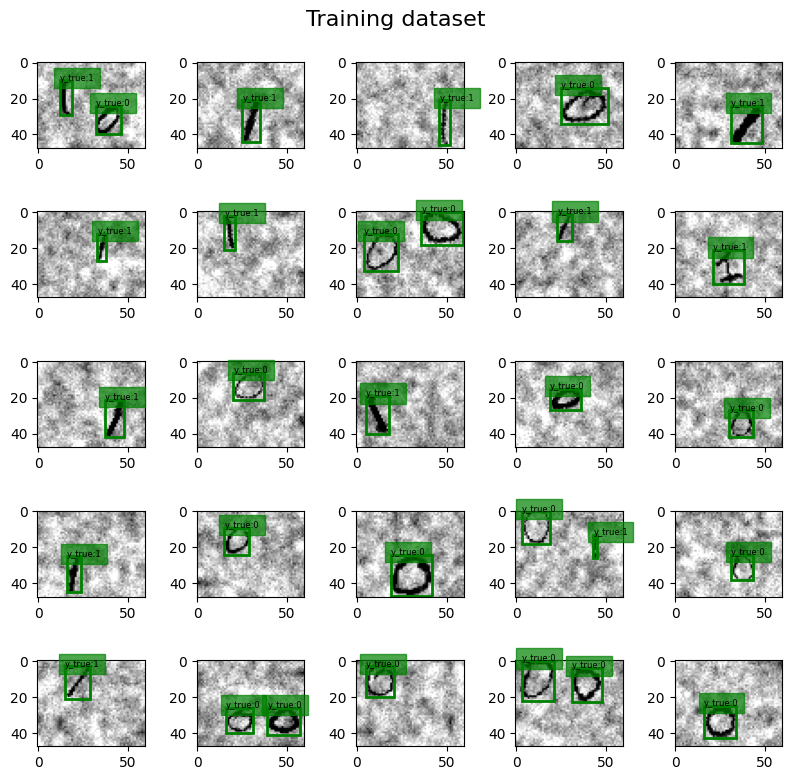

In [395]:
plot_data_det(x_train_det, "Training dataset")

In [396]:
def loss_fn_det(y_true, y_pred):
    total_loss = 0
    for h in range(len(y_true[0])):
        for w in range(len(y_true[0][0]) - 1):
            total_loss += loss_fn_loc(y_true[h][w], y_pred[h][w])

    return total_loss

In [397]:
def performance_det(y_true, y_pred):
    accuracy_val, iou_val, performance_val = 0, 0, 0
    for h in range(len(y_true[0])):
        for w in range(len(y_true[0][0]) - 1):
            a, i, p = [x / 6 for x in performance(y_pred[h][w], y_true[h][w])]
            accuracy_val += a
            iou_val += i
            performance_val += p

    return [accuracy_val, iou_val, performance_val]

3.1.2.3 Train models

In [398]:
def train_det(n_epochs, model, optimizer, loss_fn, loader):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    losses, performs = [], []

    for epoch in range(n_epochs):
        epoch_loss, epoch_perform = [], []

        for imgs, y_true in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            y_true = y_true.to(device=device)

            y_pred = model(imgs)
            y_pred = y_pred.reshape([y_pred.size()[0], 2, 3, 7])

            loss = loss_fn(y_true.float(), y_pred.float())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad(set_to_none=True)

            perform = performance_det(y_true, y_pred)[2]
            epoch_loss.append(loss.item())
            epoch_perform.append(perform.item())

        losses.append(np.mean(epoch_loss))
        performs.append(np.mean(epoch_perform))

        print(f"Epoch {epoch + 1}: {performs[-1]}, {losses[-1]}")

    return performs, losses

In [399]:
batch_size_det = 64
lr_det = 1e-3
epochs_det = 5

train_loader_det = torch.utils.data.DataLoader(x_train_det, batch_size=batch_size_det, shuffle=True)
val_loader_det = torch.utils.data.DataLoader(x_val_det, batch_size=batch_size_det, shuffle=True)

In [400]:
AlexNet_model_det = AlexNet().to(device)
AlexNet_optimizer_det = torch.optim.Adam(AlexNet_model_det.parameters(), lr=lr_det)

In [401]:
perform_AlexNet_det, losses_AlexNet_det  = train_det(epochs_det, AlexNet_model_det, AlexNet_optimizer_det, loss_fn_det, train_loader_det)

KeyboardInterrupt: 

In [ ]:
AlexNet_performance = model_performance(AlexNet_model_det, train_loader_det, perform_AlexNet_det, det=True)